In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms


In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allows loading incomplete files
from PIL import Image

In [23]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE
import seaborn as sns

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset class
class SkinImageDataset(Dataset):
    def __init__(self, metadata_csv, image_dirs, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.image_dirs = image_dirs
        self.transform = transform

        # Convert labels to class indices
        self.label2idx = {label: i for i, label in enumerate(self.metadata['diagnostic'].unique())}
        self.metadata['label_idx'] = self.metadata['diagnostic'].map(self.label2idx)

    def __len__(self):
        return len(self.metadata)

    def find_image_path(self, img_id):
        for folder in self.image_dirs:
            path = os.path.join(folder, img_id)
            if os.path.exists(path):
                return path
        raise FileNotFoundError(f"{img_id} not found.")

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = self.find_image_path(row['img_id'])

        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img = Image.new("RGB", (224, 224), color='black')

        if self.transform:
            img = self.transform(img)

        label = row['label_idx']
        return img, label


In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Paths
IMAGE_DIRS = ["/content/drive/MyDrive/skin disease detection fusion model/images1",
              "/content/drive/MyDrive/skin disease detection fusion model/images2",
              "/content/drive/MyDrive/skin disease detection fusion model/images3"]
CSV_PATH = "/content/drive/MyDrive/skin disease detection fusion model/cleaned_metadata.csv"

# Dataset & loader
dataset = SkinImageDataset(CSV_PATH, IMAGE_DIRS, transform)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [25]:
class ConvAutoencoder(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 112x112
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 56x56
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 28x28
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, feature_dim),
        )

class EndToEndNet(nn.Module):
    def __init__(self, feature_dim=128, num_classes=6):
        super().__init__()
        self.encoder = ConvAutoencoder(feature_dim=feature_dim).encoder
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(feature_dim),
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x), x


In [26]:
# Compute class weights
labels = [label for _, label in dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

# Loss, model, optimizer
model = EndToEndNet(num_classes=len(class_weights)).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs, _ = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 1.6657
Epoch 2/10, Loss: 1.3745
Epoch 3/10, Loss: 1.2946
Epoch 4/10, Loss: 1.2236
Epoch 5/10, Loss: 1.1344
Epoch 6/10, Loss: 1.0270
Epoch 7/10, Loss: 0.6926
Epoch 8/10, Loss: 0.4062
Epoch 9/10, Loss: 0.1918
Epoch 10/10, Loss: 0.1064


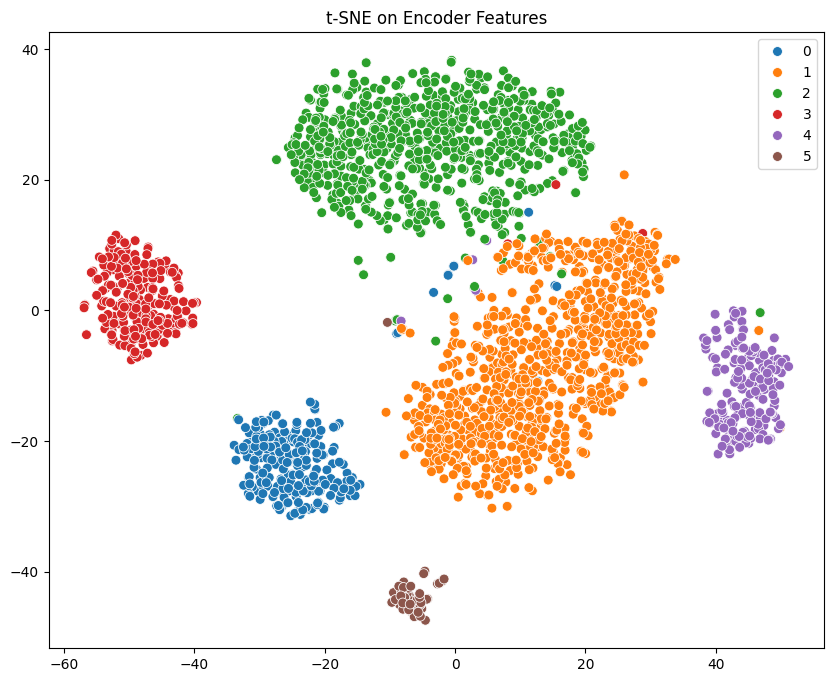

In [27]:
# Collect features and labels
model.eval()
all_feats, all_labels = [], []
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE)
        _, feats = model(imgs)
        all_feats.append(feats.cpu())
        all_labels.append(labels)

X = torch.cat(all_feats).numpy()
y = torch.cat(all_labels).numpy()

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10', s=50)
plt.title("t-SNE on Encoder Features")
plt.show()


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs, _ = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    # Classification Report
    print("📊 Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Metrics
    print(f" Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f" Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f" Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f" F1 Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67       244
           1       0.57      0.99      0.72       845
           2       1.00      0.07      0.14       730
           3       1.00      0.71      0.83       235
           4       0.44      1.00      0.61       192
           5       1.00      1.00      1.00        52

    accuracy                           0.62      2298
   macro avg       0.84      0.71      0.66      2298
weighted avg       0.80      0.62      0.54      2298



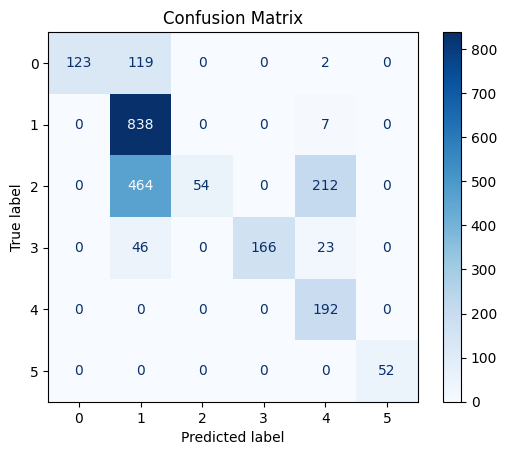

 Accuracy:  0.6201
 Precision: 0.7956
 Recall:    0.6201
 F1 Score:  0.5399


In [29]:
evaluate_model(model, train_loader)  # You can split into train/val if needed


# top selectors

In [74]:

# Dataset
class SkinImageDataset(Dataset):
    def __init__(self, metadata_csv, image_dirs, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.image_dirs = image_dirs
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(self.metadata['diagnostic'].unique())}
        self.metadata['label'] = self.metadata['diagnostic'].map(self.label_map)
        self.meta_features = self.metadata.drop(columns=['img_id', 'diagnostic', 'label'])
        self.meta_features = self.meta_features.astype(np.float32)

    def find_image_path(self, img_id):
        for folder in self.image_dirs:
            path = os.path.join(folder, img_id)
            if os.path.exists(path):
                return path
        raise FileNotFoundError(f"{img_id} not found in any folder.")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = self.find_image_path(row['img_id'])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        meta = torch.tensor(self.meta_features.iloc[idx].astype(np.float32).values)
        return img, meta, row['label']

In [75]:
# Model
class ConvAutoencoder(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, feature_dim)
        )

class FusionNet(nn.Module):
    def __init__(self, feature_dim=128, meta_dim=10, num_classes=6):
        super().__init__()
        self.encoder = ConvAutoencoder(feature_dim).encoder
        self.meta_processor = nn.Sequential(
            nn.Linear(meta_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim + 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, img, meta):
        z_img = self.encoder(img)
        z_meta = self.meta_processor(meta)
        z = torch.cat([z_img, z_meta], dim=1)
        return self.classifier(z), z

In [76]:
# Paths and transforms
IMAGE_DIRS = ["/content/drive/MyDrive/skin disease detection fusion model/images1",
              "/content/drive/MyDrive/skin disease detection fusion model/images2",
              "/content/drive/MyDrive/skin disease detection fusion model/images3"]

CSV_PATH = "/content/drive/MyDrive/skin disease detection fusion model/cleaned_metadata.csv"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Load dataset
full_dataset = SkinImageDataset(CSV_PATH, IMAGE_DIRS, transform)
labels = [full_dataset[i][2] for i in range(len(full_dataset))]


In [78]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Top-K metadata selection
meta_all = torch.stack([full_dataset[i][1] for i in range(len(full_dataset))]).numpy()
selector = SelectKBest(mutual_info_classif, k=10)
meta_selected = selector.fit_transform(meta_all, labels)
full_dataset.meta_features = pd.DataFrame(meta_selected)

# Stratified split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(np.zeros(len(labels)), labels))
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Class weights
train_labels = [full_dataset[i][2] for i in train_idx]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Model setup
DEVICE = torch.device("cpu")
model = FusionNet(feature_dim=128, meta_dim=10, num_classes=6).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
EPOCHS = 25
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(DEVICE), metas.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs, _ = model(imgs, metas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/25, Loss: 1.5666
Epoch 2/25, Loss: 1.1011
Epoch 3/25, Loss: 0.8932
Epoch 4/25, Loss: 0.8405
Epoch 5/25, Loss: 0.8172
Epoch 6/25, Loss: 0.8266
Epoch 7/25, Loss: 0.7712
Epoch 8/25, Loss: 0.7479
Epoch 9/25, Loss: 0.7449
Epoch 10/25, Loss: 0.7297
Epoch 11/25, Loss: 0.7333
Epoch 12/25, Loss: 0.7144
Epoch 13/25, Loss: 0.7339
Epoch 14/25, Loss: 0.7222
Epoch 15/25, Loss: 0.7001
Epoch 16/25, Loss: 0.6967
Epoch 17/25, Loss: 0.6762
Epoch 18/25, Loss: 0.6581
Epoch 19/25, Loss: 0.6668
Epoch 20/25, Loss: 0.6542
Epoch 21/25, Loss: 0.6360
Epoch 22/25, Loss: 0.6313
Epoch 23/25, Loss: 0.6276
Epoch 24/25, Loss: 0.6438
Epoch 25/25, Loss: 0.6282



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        49
           1       0.81      0.73      0.77       169
           2       0.87      0.73      0.79       146
           3       0.78      0.81      0.79        47
           4       0.28      0.49      0.35        39
           5       0.38      0.80      0.52        10

    accuracy                           0.73       460
   macro avg       0.66      0.73      0.68       460
weighted avg       0.78      0.73      0.75       460


Confusion Matrix:


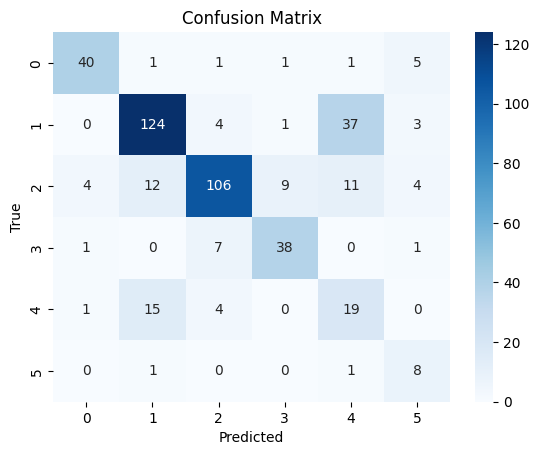

In [80]:
# Evaluation
model.eval()
all_preds, all_labels, all_feats = [], [], []
with torch.no_grad():
    for imgs, metas, labels in val_loader:
        imgs, metas = imgs.to(DEVICE), metas.to(DEVICE)
        outputs, feats = model(imgs, metas)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(labels)
        all_feats.append(feats.cpu())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


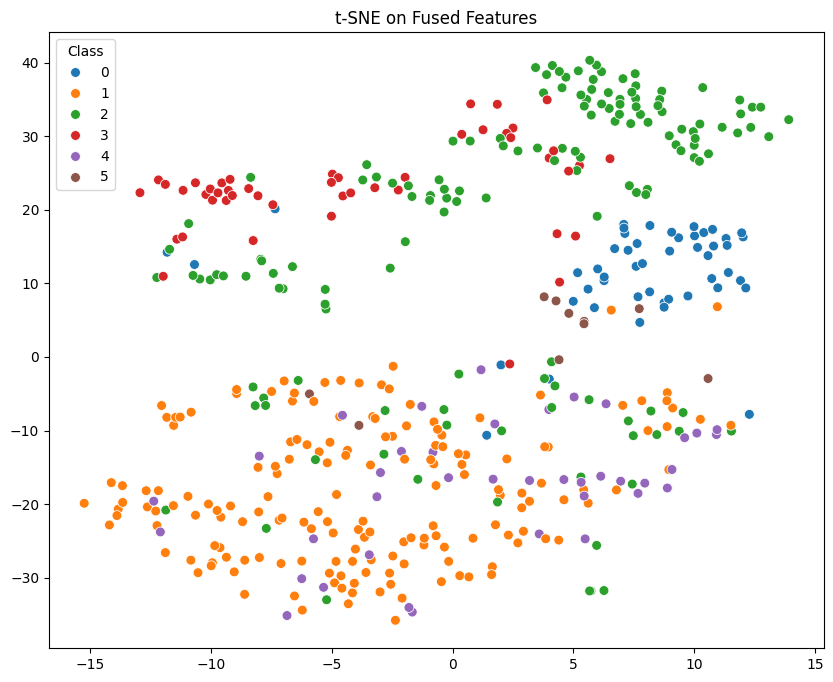

In [81]:
# t-SNE Plot
features_np = torch.cat(all_feats).numpy()
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings = tsne.fit_transform(features_np)

# Ensure labels are integers for proper hue mapping
labels_np = np.array(all_labels, dtype=int)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=labels_np, palette="tab10", s=50, legend='full')
plt.legend(title="Class", loc='best')
plt.title("t-SNE on Fused Features")
plt.show()


# Model Comparison

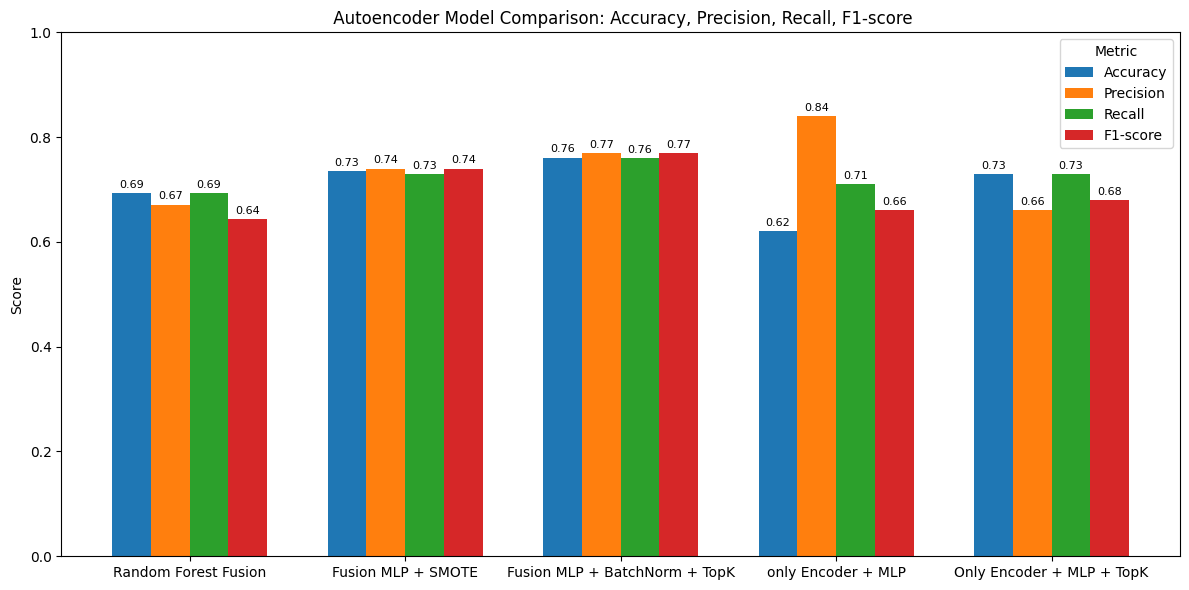

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Updated metrics including real Encoder-only results
metrics = {
    "Random Forest Fusion": {
        "Accuracy": 0.693,
        "Precision": 0.671,
        "Recall": 0.693,
        "F1-score": 0.644
    },
    "Fusion MLP + SMOTE": {
        "Accuracy": 0.735,
        "Precision": 0.74,
        "Recall": 0.73,
        "F1-score": 0.74
    },
    "Fusion MLP + BatchNorm + TopK": {
        "Accuracy": 0.7609,
        "Precision": 0.77,
        "Recall": 0.76,
        "F1-score": 0.77
    },
    "only Encoder + MLP": {
        "Accuracy": 0.62,
        "Precision": 0.84,
        "Recall": 0.71,
        "F1-score": 0.66
    },
    "Only Encoder + MLP + TopK": {
        "Accuracy": 0.73,
        "Precision": 0.66,
        "Recall": 0.73,
        "F1-score": 0.68
    }
}

# Models and metrics
model_names = list(metrics.keys())
metric_names = list(metrics[model_names[0]].keys())

# Organize the metric values per metric
values_by_metric = {metric: [metrics[model][metric] for model in model_names] for metric in metric_names}

# Plot settings
x = np.arange(len(model_names))
width = 0.18  # Adjusted for 5 models

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each metric
for i, metric in enumerate(metric_names):
    ax.bar(x + i * width, values_by_metric[metric], width, label=metric)

# Labeling
ax.set_ylabel("Score")
ax.set_title(" Autoencoder Model Comparison: Accuracy, Precision, Recall, F1-score")
ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
ax.set_xticklabels(model_names, rotation=0)
ax.set_ylim([0, 1])
ax.legend(title="Metric")

# Add value labels on bars
for i, metric in enumerate(metric_names):
    for j, value in enumerate(values_by_metric[metric]):
        ax.text(j + i * width, value + 0.01, f"{value:.2f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()
